# Test Download Embeddings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ee
from tqdm import tqdm
from mangroves.collection import Collection
from mangroves.geometry import Region
from mangroves.utils import haversine, geodesic_circle, planar_approx_circle
from mangroves.constants import BANDS

with open('/home/nus/workspace/tutorial/GEE/gee_project_key.txt', "r") as f:
    project = f.readline().strip()

collection = Collection(project=project)

2025-11-21 15:19:33,077 - INFO - Google Earth Engine initialized successfully with service account


### Inputs

In [2]:
nPixels = 256
lat0_deg = 1.41150
lon0_deg = 103.9569
year = 2018

### Reference Point

In [ ]:
pt0 = ee.Geometry.Point([lon0_deg, lat0_deg], proj='EPSG:4326')
img = ee.Image(ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
               .filterDate(f'{year}-01-01', f'{year+1}-01-01')
               .filterBounds(pt0)
               .first())
pixel_data = img.select(BANDS).sample(pt0)
values0 = np.array(list(pixel_data.getInfo()['features'][0]['properties'].values()))

### Download Image

Pixel corner distances: [np.float64(1810.1933598375465), np.float64(1810.1933598341577), np.float64(1810.1933598375465), np.float64(1810.193359836392)]


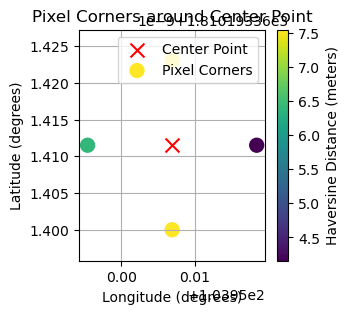

In [4]:
region = Region(lat_deg=lat0_deg, lon_deg=lon0_deg, nPixels=nPixels)

pts_distance = [
    np.sqrt(2. * haversine(lat0_deg, lat_deg, lon0_deg, lon_deg)**2) for lat_deg, lon_deg in region.pts
]

print("Pixel corner distances:", pts_distance)

plt.figure(figsize=(3, 3))
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
plt.scatter(
    [lon for _, lon in region.pts],
    [lat for lat, _ in region.pts],
    marker='o',
    s=100,
    label='Pixel Corners',
    c=pts_distance,
    cmap='viridis',
)
plt.colorbar(label='Haversine Distance (meters)')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Pixel Corners around Center Point')
plt.axis('equal')
plt.legend()
plt.grid()

In [ ]:
pixel_data = img.select(BANDS).sampleRectangle(region=region.region, properties=[], defaultValue=0)
out = pixel_data.getInfo()
props = out['properties']

# plt.figure(figsize=(3, 3))
# plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
# plt.plot(xMin, yMin, 'go', label='Bottom Left')
# plt.plot(xMax, yMin, 'bo', label='Bottom Right')
# plt.plot(xMax, yMax, 'ro', label='Top Right')
# plt.plot(xMin, yMax, 'yo', label='Top Left')
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Region for sampleRectangle')
# plt.axis('equal')
# plt.legend()
# plt.grid()

In [6]:
region_coordinates = region.region.getInfo()['coordinates'][0]

distance_corners = [
    haversine(lat0_deg, lat, lon0_deg, lon) for lon, lat in region_coordinates
]

distance_corners

[np.float64(1810.1955940758091),
 np.float64(1810.1955940746923),
 np.float64(1810.1911133995334),
 np.float64(1810.1911134006502),
 np.float64(1810.1955940758091)]

In [ ]:
bands_data = {}
for i in range(64):
    band_name = BANDS[i]
    if band_name in props:
        band_array = np.array(props[band_name])
        band_array = np.flipud(band_array)  # Apply flipud for correct display
        bands_data[band_name] = band_array

image_stack = []
for band_name in BANDS:
    if band_name in bands_data:
        image_stack.append(bands_data[band_name])
    else:
        # Fill missing bands with zeros
        if bands_data:
            image_shape = list(bands_data.values())[0].shape
            image_stack.append(np.zeros(image_shape))

# Stack to create D*H*W array
patch = np.stack(image_stack, axis=0)
patch.shape

(64, 256, 257)

In [ ]:
scale = ee.Number(1)

# Transform center to band projection and snap to nearest pixel center
pt_proj = pt.transform(proj, 1)
x = ee.Number(pt_proj.coordinates().get(0))
y = ee.Number(pt_proj.coordinates().get(1))
x_center = x.divide(scale).round().multiply(scale)
y_center = y.divide(scale).round().multiply(scale)

# Half-size = 128 pixels * pixel size
half = scale.multiply(patch_size // 2)
eps = ee.Number(1e-6)

xmin = x_center.subtract(half).add(eps)
xmax = x_center.add(half).subtract(eps)
ymin = y_center.subtract(half).add(eps)
ymax = y_center.add(half).subtract(eps)
region = ee.Geometry.Rectangle(ee.List([xmin, ymin, xmax, ymax]), proj, False)

# Sanity checks (must be 256 each)
width_px = xmax.subtract(xmin).divide(scale)
height_px = ymax.subtract(ymin).divide(scale)
print('projection:', proj.getInfo())
print('nominalScale:', scale.getInfo())
print('width_px:', width_px.getInfo(), 'height_px:', height_px.getInfo())

# Only proceed if both are 256
pixel_data = img.select(bands).sampleRectangle(region=region, properties=[], defaultValue=0)
out = pixel_data.getInfo()
props = out['properties']

projection: {'type': 'Projection', 'crs': 'EPSG:32648', 'transform': [10, 0, 336160, 0, 10, 0]}
nominalScale: 1
width_px: 255.99999799999932 height_px: 255.99999799999932


In [176]:
bands_data = {}
for i in range(64):
    band_name = f'A{i:02d}'
    if band_name in props:
        band_array = np.array(props[band_name])
        # Apply flipud for correct display
        band_array = np.flipud(band_array)
        bands_data[band_name] = band_array

bands_data

{'A00': array([[-0.04484429, -0.02977316, -0.02712803, ..., -0.11374087,
         -0.11374087, -0.11909266],
        [-0.02712803, -0.01384083, -0.0120569 , ..., -0.11909266,
         -0.11909266, -0.11909266],
        [-0.02220684, -0.0120569 , -0.0120569 , ..., -0.11909266,
         -0.11909266, -0.11909266],
        ...,
        [-0.11374087, -0.11374087, -0.11374087, ..., -0.10851211,
         -0.10851211, -0.11374087],
        [-0.11374087, -0.11374087, -0.11374087, ..., -0.10851211,
         -0.10851211, -0.11374087],
        [-0.11374087, -0.11374087, -0.11374087, ..., -0.10340638,
         -0.10851211, -0.11374087]], shape=(256, 256)),
 'A01': array([[-0.08421376, -0.09356401, -0.10340638, ..., -0.11909266,
         -0.11909266, -0.12456747],
        [-0.08421376, -0.07111111, -0.08421376, ..., -0.11374087,
         -0.11374087, -0.11909266],
        [-0.07972318, -0.07111111, -0.08421376, ..., -0.11374087,
         -0.11374087, -0.11909266],
        ...,
        [-0.12456747, 

In [179]:
band_names = [f'A{i:02d}' for i in range(64)]
image_stack = []
            
for band_name in band_names:
    if band_name in bands_data:
        image_stack.append(bands_data[band_name])
    else:
        # Fill missing bands with zeros
        if bands_data:
            image_shape = list(bands_data.values())[0].shape
            image_stack.append(np.zeros(image_shape))

# Stack to create D*H*W array
patch = np.stack(image_stack, axis=0)
patch.shape

(64, 256, 256)